## Exercise 1

Read the edgelist and the nodelist of the dummy multilayer network, and create the following adjacency matrices:
* parent-child
* family
* household
* neighbor
* school
* work

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [5]:
# read data
nodes = pd.read_csv('data/popnet_nodelist.csv',index_col=None,header=0)
edges = pd.read_csv('data/popnet_edgelist.csv',index_col=None,header=0)

In [87]:
edges.head(2)

,source,target,edgetype
0,127,164,aunt / uncle
1,68,181,neighbor


In [86]:
nodes.head(2)

,node_id,generation,gender
0,50,1,1
1,51,1,1


In [88]:
print(edges["edgetype"].unique())

['aunt / uncle' 'neighbor' 'cousin' 'mother / father-in-law' 'sibling'
 'household' 'grandchild' 'grandparent' 'partner' 'work' 'niece / nephew'
 'parent' 'sister / brother-in-law' 'school' 'child'
 'daughter / son-in-law']


In [57]:
# create empty dictionary
adj_dict = dict()

# loop over groups
for edge, data in edges.groupby("edgetype"):
    # create newtork
    G = nx.from_edgelist(data[["source","target"]].values)
    # add missing links
    G.add_nodes_from(nodes["node_id"])
    # create adjacency matrix and save to dictionary
    adj_dict[edge] = nx.to_scipy_sparse_array(G, nodelist=nodes["node_id"])
    
    
# Alternative
# loop over groups
for edge in edges["edgetype"].unique():
    # create newtork
    G = nx.from_edgelist(edges.loc[edges["edgetype"]==edge, ["source","target"]].values)
    # add missing links
    G.add_nodes_from(nodes["node_id"])
    # create adjacency matrix and save to dictionary
    adj_dict[edge] = nx.to_scipy_sparse_array(G, nodelist=nodes["node_id"])
    

In [89]:
# Create family (you could also sum the adjacency matrixes)
family = ['aunt / uncle', 'neighbor', 'cousin', 'mother / father-in-law', 'sibling',  'grandchild', 'grandparent',  'niece / nephew', 'parent', 'sister / brother-in-law',  'child', 'daughter / son-in-law']
G_total = nx.from_edgelist(edges.loc[edges["edgetype"].isin(family), ["source","target"]].values)
G_total.add_nodes_from(nodes["node_id"])
adj_dict["family"] = nx.to_scipy_sparse_array(G_total, nodelist=nodes["node_id"])

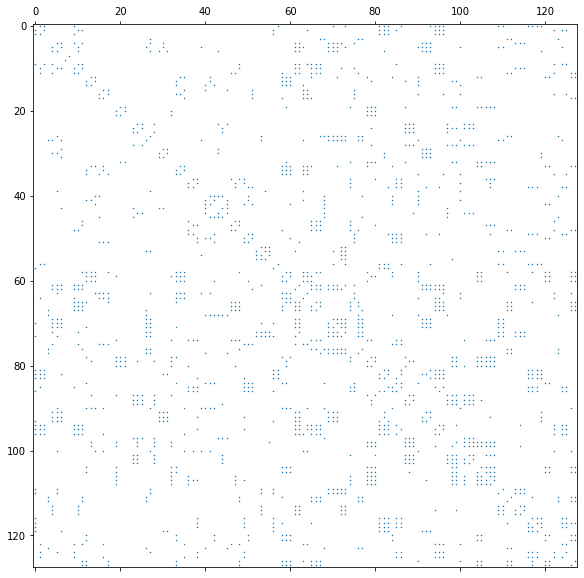

In [59]:
# show network
plt.subplots(1,1,figsize=(10,10))
plt.spy(adj_dict["family"],alpha=1,markersize=0.5)

## Exercise 2

Using the five main layers (leaving out the parent-child), calculate and visualize the distribution of the degree, and the number of layers a node participates in!

In [67]:
# Create degrees
degree = {}
for layer in ['family','household','work','school','neighbor']:
    degree[layer] = adj_dict[layer].sum(axis=0)

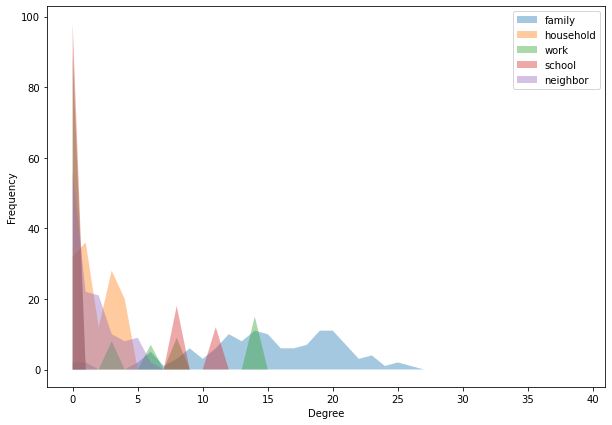

In [71]:
# Plot degrees
plt.figure(figsize=(10,7))
for layer in degree:
    y,x = np.histogram(degree[layer],range=(0,40),bins=40)
    plt.fill_between(x[:-1],y,alpha=0.4,label=layer)
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()

## Exercise 3

List the parents of the classmates of all the nodes that are currently attending school! Solve the exercise with matrix multiplication! Explain why you might have gotten elements larger than 1 in the multiplication result!

In [78]:
# find parents of classmates
A_parents_classmates = (adj_dict["school"] @ adj_dict["child"])
# create network
G = nx.from_scipy_sparse_array(A_parents_classmates)
# export as an adjacency list
nx.to_pandas_edgelist(G)

,source,target,weight
0,58,104,2
1,58,105,2
2,58,106,2
3,58,107,2
4,58,108,2
...,...,...,...
287,97,114,3
288,97,115,3
289,97,116,3
290,97,117,3


## Exercise 4

How could you detect parallel edges, e.g. edges that exist in multiple different layers between two nodes? List all such edges with the corresponding layers!

In [79]:
A = csr_matrix((N,N))

for layer in ['family','household','work','school','neighbor']:
    A += adj_dict[layer]
    
multiedges = pd.DataFrame((A>1).nonzero()).T

def isin_layer(*edge):
    res = []
    for layer in ['family','household','work','school','neighbor']:
        if adj_dict[layer][edge]:
            res.append(layer)
    return res

In [80]:
multiedges.columns = ["source","target"]
multiedges["layers"] = multiedges.apply(lambda r: isin_layer(*r),axis=1)

In [81]:
multiedges

,source,target,layers
0,0,70,"[family, neighbor]"
1,0,73,"[family, neighbor]"
2,0,109,"[family, neighbor]"
3,0,110,"[family, neighbor]"
4,4,61,"[family, neighbor]"
...,...,...,...
444,127,104,"[family, school]"
445,127,105,"[family, school]"
446,127,111,"[family, neighbor]"
447,127,117,"[family, neighbor]"


## Exercise 5

Try to load the network into `pymnet`, and experiment with the visualization. Try to solve the previous exercises using `pymnet`. Attention, this approach won't work for larger networks!

## Exercise 6

Enumerate the connected components of each layer, calculate their sizes, list them! What do they correspond to?

In [82]:
for layer in ['family','household','work','school','neighbor']:
    print(sorted([len(c) for c in nx.connected_components(nx.from_scipy_sparse_matrix(adj_dict[layer]))],key=lambda x: -x))

[124, 2, 1, 1]
[5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[15, 9, 7, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[12, 9, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[25, 14, 6, 4, 4, 4, 4, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/var/folders/hx/nz98f65j615c4ygz7xt694700000gp/T/ipykernel_7932/740100797.py:2: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  print(sorted([len(c) for c in nx.connected_components(nx.from_scipy_sparse_matrix(adj_dict[layer]))],key=lambda x: -x))


## Exercise 7

Let's suppose that all of these people suddenly meet at a festival where they compete in groups with each other. The group assignment is random, there are 5 different groups, and everyone is part of exactly one group.

Create such a random assignment! Create the corresponding "affiliation matrix"!

Create the adjacency matrix of people based on group co-affiliation!

In [83]:
groups = np.random.randint(low=0,high=5,size=(N,))
aff = csr_matrix((np.ones(N),(range(N),groups)),shape=(N,5)).todense()

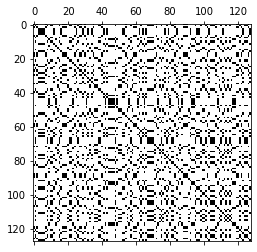

In [84]:
plt.spy(aff @ aff.T)

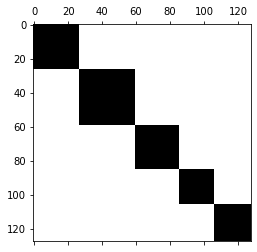

In [85]:
plt.spy(aff[np.argsort(groups),:] @ aff.T[:,np.argsort(groups)])